## Import & Process Image

In [22]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import glob

# from src.functions import preprocess_image, load_and_preprocess_image

AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

pd.options.display.max_columns = 100

## Data Cleaning

In [18]:
## This code will only work if you have all the images already downloaded on your EC2
img_url = sorted(glob.glob('data/ISIC-images'+"/*.jpg"))
csv_names = [i for i in glob.glob('data'+'/*.csv')]
df = pd.read_csv('data/metadata.csv')

short=[]
for i in img_url:
    short.append(i[17:-4])
img_name = pd.Series(short,name='name')

df = pd.merge(df, img_name, on='name', how='inner')
df['image'] = img_url

df = df[['meta.clinical.diagnosis', 'image']]
df_na = df.copy()
df = df[df['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
df.columns = ['diagnosis', 'image']
df['diagnosis'] = (df['diagnosis'] == 'melanoma').astype(int)

#### Deleted null values from dataset

In [3]:
df_na[df_na['meta.clinical.diagnosis'].isna()]

,meta.clinical.diagnosis,image
257,NaN,data/ISIC-images/ISIC_0000257.jpg
454,NaN,data/ISIC-images/ISIC_0000454.jpg
9892,NaN,data/ISIC-images/ISIC_0009892.jpg
9893,NaN,data/ISIC-images/ISIC_0009893.jpg
9924,NaN,data/ISIC-images/ISIC_0009924.jpg
...,...,...
13786,NaN,data/ISIC-images/ISIC_0024202.jpg
13787,NaN,data/ISIC-images/ISIC_0024203.jpg
13788,NaN,data/ISIC-images/ISIC_0024204.jpg
13789,NaN,data/ISIC-images/ISIC_0024205.jpg


##### df = All dataset

## EDA

In [4]:
diagnosis = df['diagnosis']

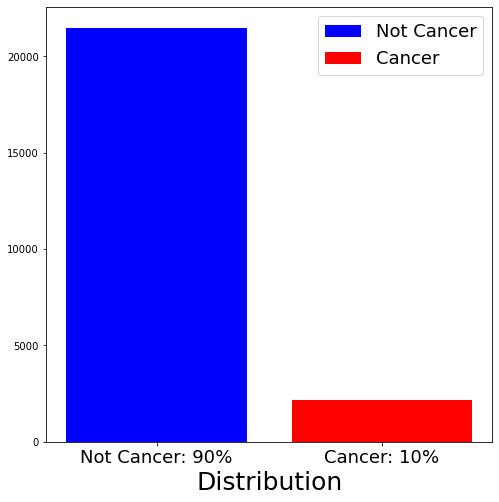

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
xlabel = 25
xtick = 18
x0 = (diagnosis==0).sum()
x1 = (diagnosis==1).sum()

ax.set_xlabel('Distribution', size=xlabel)

ax.bar(0, x0, color = 'b', label='Not Cancer')
ax.bar(1, x1, color = 'r', label='Cancer')
ax.set_xticks([0,1])
ax.set_xticklabels(['Not Cancer: 90%', 'Cancer: 10%'], size=xtick)
plt.legend(prop={'size': 18})
plt.show()

## Pipeline

In [6]:
def preprocess_image(image, imgage_shape=[100,100]):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, imgage_shape)
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def create_X_y(df):
    y = df['diagnosis']
    X = []
    for i in df['image']:
        image = load_and_preprocess_image(i)
        X.append(np.asarray(image))
    return np.asarray(X), np.asarray(y)

#### Creating Test Set and Save processed image set

In [27]:
# Code to create X and y.
# X, y = create_X_y(df)

In [22]:
# np.save('data/100x100.npy', X)
# np.save('data/diagnosis.npy', y)

In [23]:
import boto3
s3 = boto3.client('s3')

In [7]:
# Uploading 'X' to AWS S3 from original AWS instance
s3.upload_file(Filename='data/100x100.npy',
              Bucket='cancer-images-project',
              Key='100x100.npy')

In [21]:
# Downloading 'X' from AWS S3 to new AWS instance
s3.download_file(Bucket='cancer-images-project',
                 Key='100x100.npy',
                 Filename='data/100x100.npy')

In [24]:
# Uploading 'y' to AWS S3 from original AWS instance
s3.upload_file(Filename='data/diagnosis.npy',
              Bucket='cancer-images-project',
              Key='diagnosis.npy')

In [24]:
# Downloading 'y' from AWS S3 to new AWS instance
s3.download_file(Bucket='cancer-images-project',
                 Key='diagnosis.npy',
                 Filename='data/diagnosis.npy')

#### Train Test Split for Train, validation, test set

In [30]:
X = np.load('data/100x100.npy')
y = np.load('data/diagnosis.npy')

In [31]:
# Train/test split for Train Set
XX_train, X_test, yy_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(XX_train, yy_train, test_size=0.2, random_state=42, stratify=yy_train)

#### Train Model

In [70]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [71]:
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [72]:
class_weight = {1:0.9,
                0:0.1}

In [73]:
history = model.fit(X_train, y_train, epochs=20, class_weight=class_weight, validation_data=(X_test, y_test))

Epoch 1/20
474/474 [==============================] - 54s 114ms/step - loss: 0.1218 - accuracy: 0.7215 - recall_4: 0.2350 - val_loss: 0.6571 - val_accuracy: 0.9083 - val_recall_4: 0.0000e+00
Epoch 2/20
474/474 [==============================] - 54s 113ms/step - loss: 0.1200 - accuracy: 0.9084 - recall_4: 0.0000e+00 - val_loss: 0.6584 - val_accuracy: 0.9083 - val_recall_4: 0.0000e+00
Epoch 3/20
474/474 [==============================] - 53s 111ms/step - loss: 0.1200 - accuracy: 0.9084 - recall_4: 0.0000e+00 - val_loss: 0.6506 - val_accuracy: 0.9083 - val_recall_4: 0.0000e+00
Epoch 4/20
474/474 [==============================] - 53s 112ms/step - loss: 0.1200 - accuracy: 0.9084 - recall_4: 0.0000e+00 - val_loss: 0.6554 - val_accuracy: 0.9083 - val_recall_4: 0.0000e+00
Epoch 5/20
474/474 [==============================] - 53s 111ms/step - loss: 0.1200 - accuracy: 0.9084 - recall_4: 0.0000e+00 - val_loss: 0.6319 - val_accuracy: 0.9083 - val_recall_4: 0.0000e+00
Epoch 6/20
474/474 [=========

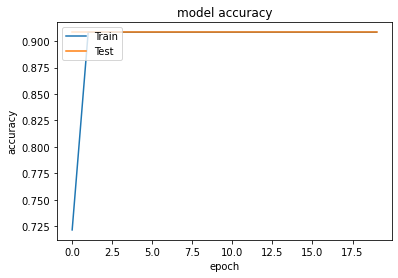

In [74]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

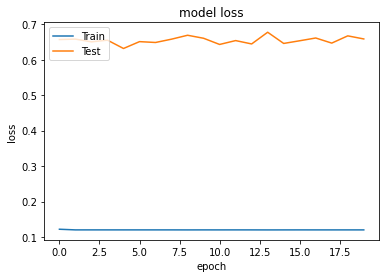

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [57]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall_2', 'val_loss', 'val_accuracy', 'val_recall_2'])

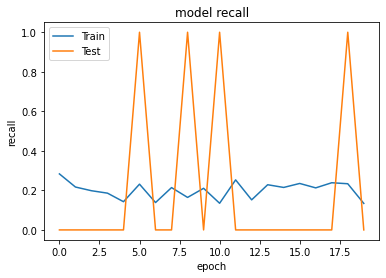

In [58]:
plt.plot(history.history['recall_2'])
plt.plot(history.history['val_recall_2'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 64)       

## Evalaution

In [60]:
# Validation Set
val_loss, val_acc, val_recall = model.evaluate(X_val, y_val, verbose=0)
print('Val  set accuracy {:5.2f}%'.format(100*val_acc))
print('Val  set recall   {:5.2f}%'.format(100*val_recall))

# Test Set
test_loss, test_acc, test_recall = model.evaluate(X_test, y_test, verbose=0)
print('Test set accuracy {:5.2f}%'.format(100*test_acc))
print('Test set recall   {:5.2f}%'.format(100*test_recall))


Val  set accuracy 90.83%
Val  set recall    0.00%
Test set accuracy 90.83%
Test set recall    0.00%


In [61]:
def matrix_score(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(np.array([[tp, fn],[fp, tn]]))
    print('Recall:    {:.3f}'.format(tp/(tp+fn)))
    print('Precision: {:.3f}'.format(tp/(tp+fp)))
    print('Accuracy:  {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('ROC AUC:   {:.3f}'.format(roc_auc_score(y_test, y_pred)))

In [62]:
threshold = 0.5

In [63]:
# Validation Set
result = (model.predict(X_val) > threshold).astype(int)
result =[i[0] for i in result]
y_val_pred = np.asarray(result)

matrix_score(y_val, y_val_pred)

[[   0  347]
 [   0 3438]]
Recall:    0.000
Precision: nan
Accuracy:  0.908
ROC AUC:   0.500


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [45]:
# Test Set
result = (model.predict(X_test) > threshold).astype(int)
result =[i[0] for i in result]
y_test_pred = np.asarray(result)

matrix_score(y_test, y_test_pred)

[[ 347   87]
 [1170 3127]]
Recall:    0.800
Precision: 0.229
Accuracy:  0.734
ROC AUC:   0.764


## ROC AUC

In [47]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred)
auc_keras = auc(fpr_keras, tpr_keras)

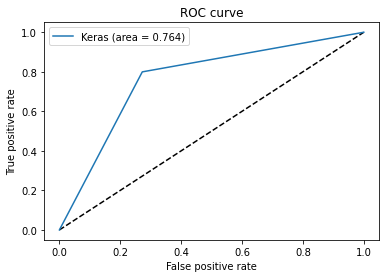

In [48]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

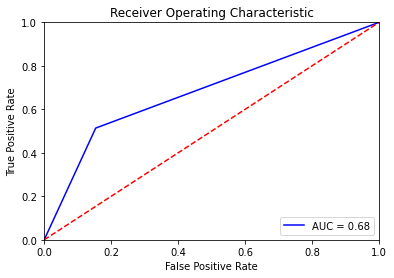

In [31]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()